### RED CGAN:
Básicamente una red cGAN es una variante de las GANs (Generative Adversarial Networks) que incorpora una condición o etiqueta adicional tanto en el generador como en el discriminador. Esto permite generar muestras condicionadas a información específica lo que resulta útil en tareas de generación o manipulación de datos.


Lo primero que hacemos es importar las librerías que vamos a usar a lo largo del notebook, después definimos algunas constantes de las imágenes y de las funciones que definiremos más adelante. Cargamos el datasset de MNIST y normalizamos las imágenes.

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers import LeakyReLU

# Constants
IMG_ROWS, IMG_COLS, CHANNELS = 28, 28, 1
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
NOISE_DIM = 100
NUM_CLASSES = 10

# Load MNIST dataset
(x_train, y_train), (_, _) = mnist.load_data()

# Normalize and reshape images
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# Rescale labels to one-hot vectors
y_train = np.eye(NUM_CLASSES)[y_train]

11490434/11490434 [==============================] - 0s 0us/step


Ahora vamos a definir funciones para construir el generador y el discriminador que usaremos en la propia red cGAN:

In [2]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=NOISE_DIM))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dense(np.prod(IMG_SHAPE), activation='tanh'))
    model.add(Reshape(IMG_SHAPE))

    noise = Input(shape=(NOISE_DIM,))
    label = Input(shape=(NUM_CLASSES,))
    label_embedding = Dense(NOISE_DIM)(label)

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=IMG_SHAPE, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    img = Input(shape=IMG_SHAPE)
    validity = model(img)

    return Model(img, validity)

Creamos instancias del generador y discriminador y congelamos al discriminador durante la fase de entrenamiento. Luego construimos la red uniendo el discriminador y el generador y finalmente compilamos la red CGAN usando el optimizador Adam.

In [3]:
# Build the generator
generator = build_generator()

# Build the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Freeze discriminator's weights during generator training
discriminator.trainable = False

# Build the CGAN by connecting generator and discriminator
noise = Input(shape=(NOISE_DIM,))
label = Input(shape=(NUM_CLASSES,))
img = generator([noise, label])
validity = discriminator(img)

# Compile the CGAN model
cgan = Model([noise, label], validity)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

Para entrenar nuestra red empezamos definiendo parámetros como el número de epochs y en un bucel for entrenamos el generador, el discriminador y mostramos como va el proceso a partir del loss que tengan.

In [29]:
# Training
BATCH_SIZE = 32
EPOCHS = 100
SAMPLE_INTERVAL = 10

# Adversarial ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
    real_images = x_train[idx]
    labels = y_train[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    gen_images = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, valid)
    d_loss_fake = discriminator.train_on_batch(gen_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    g_loss = cgan.train_on_batch([noise, labels], valid)

    # Print progress
    if epoch % SAMPLE_INTERVAL == 0:
        print(f"Epoch {epoch}/{EPOCHS} | Discriminator loss: {d_loss[0]:.4f}, Generator loss: {g_loss:.4f}")

1/1 [==============================] - 0s 29ms/step
Epoch 0/100 | Discriminator loss: 0.1293, Generator loss: 2.4529
1/1 [==============================] - 0s 26ms/step
Epoch 10/100 | Discriminator loss: 0.1739, Generator loss: 2.3741
1/1 [==============================] - 0s 29ms/step
Epoch 20/100 | Discriminator loss: 0.1266, Generator loss: 2.8600
1/1 [==============================] - 0s 54ms/step
Epoch 30/100 | Discriminator loss: 0.1175, Generator loss: 2.9686
1/1 [==============================] - 0s 48ms/step
Epoch 40/100 | Discriminator loss: 0.1120, Generator loss: 2.5778
1/1 [==============================] - 0s 36ms/step
Epoch 50/100 | Discriminator loss: 0.0653, Generator loss: 3.4670
1/1 [==============================] - 0s 35ms/step
Epoch 60/100 | Discriminator loss: 0.1543, Generator loss: 2.3453
1/1 [==============================] - 0s 32ms/step
Epoch 70/100 | Discriminator loss: 0.1486, Generator loss: 3.4927
1/1 [==============================] - 0s 26ms/step
Epoch

Para acabar generamos ruido y etiquetas para que la red prediga una serie de imágenes basadas en estos parámetros y vemos el resultado:

1/1 [==============================] - 0s 29ms/step


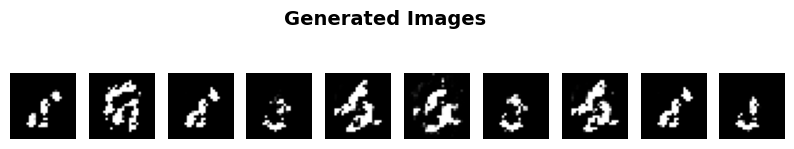

In [31]:
import matplotlib.pyplot as plt

# Generate synthetic images
num_examples = 10
noise = np.random.normal(0, 1, (num_examples, NOISE_DIM))
labels = np.eye(NUM_CLASSES)[np.arange(num_examples) % NUM_CLASSES]
generated_images = generator.predict([noise, labels])

# Rescale generated images to [0, 1]
generated_images = 0.5 * generated_images + 0.5

# Plot generated images
fig, axs = plt.subplots(1, num_examples, figsize=(10, 2))
fig.suptitle('Generated Images', fontsize=14, fontweight='bold')
for i in range(num_examples):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()